Customer Churn Analysis
Problem Statement:

Customer churn is when a company’s customers stop doing business with that company. Businesses are very keen on measuring churn because keeping an existing customer is far less expensive than acquiring a new customer. New business involves working leads through a sales funnel, using marketing and sales budgets to gain additional customers. Existing customers will often have a higher volume of service consumption and can generate additional customer referrals.

Customer retention can be achieved with good customer service and products. But the most effective way for a company to prevent attrition of customers is to truly know them. The vast volumes of data collected about customers can be used to build churn prediction models. Knowing who is most likely to defect means that a company can prioritise focused marketing efforts on that subset of their customer base.

Preventing customer churn is critically important to the telecommunications sector, as the barriers to entry for switching services are so low. 

You will examine customer data from IBM Sample Data Sets with the aim of building and comparing several customer churn prediction models. 

Note: You can find the dataset in the link below.

In [2]:
# 1. Import the libraries
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical libraries
import phik
from scipy.stats import pearsonr
from scipy.stats import zscore

from pandas.api.types import is_numeric_dtype

# feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# metrics 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, classification_report

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/DSData/master/Telecom_customer_churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# checking the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# checking the dataset statistics
df.describe().round()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.0,7043.0,7043.0
mean,0.0,32.0,65.0
std,0.0,25.0,30.0
min,0.0,0.0,18.0
25%,0.0,9.0,36.0
50%,0.0,29.0,70.0
75%,0.0,55.0,90.0
max,1.0,72.0,119.0


In [8]:
# checking for null values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [11]:
# from the above, we have 3 continuous numerical features, the customerID feature can be dropped.
df.drop('customerID', axis = 1, inplace = True)

In [16]:
# We check for the excessive occurence of 0s in the dataset
for col in df.columns[:-1]:
    idx = np.where(df[col].values == 0)
    print(f"{col:30s} : {idx[0].shape[0]/len(df)*100:0.3f}")

gender                         : 0.000
SeniorCitizen                  : 83.785
Partner                        : 0.000
Dependents                     : 0.000
tenure                         : 0.156
PhoneService                   : 0.000
MultipleLines                  : 0.000
InternetService                : 0.000
OnlineSecurity                 : 0.000
OnlineBackup                   : 0.000
DeviceProtection               : 0.000
TechSupport                    : 0.000
StreamingTV                    : 0.000
StreamingMovies                : 0.000
Contract                       : 0.000
PaperlessBilling               : 0.000
PaymentMethod                  : 0.000
MonthlyCharges                 : 0.000
TotalCharges                   : 0.000


In [19]:
# SeniorCitizen has too many zeros and hence we drop it
df.drop('SeniorCitizen', axis = 1, inplace = True)

In [20]:
df.head()


,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
# Checking for the variablility in the dataset
for col in df.columns[:-1]:
    print(f"{col:30s} : {df[col].unique().shape[0]/len(df)*100:0.3f}")

gender                         : 0.028
Partner                        : 0.028
Dependents                     : 0.028
tenure                         : 1.036
PhoneService                   : 0.028
MultipleLines                  : 0.043
InternetService                : 0.043
OnlineSecurity                 : 0.043
OnlineBackup                   : 0.043
DeviceProtection               : 0.043
TechSupport                    : 0.043
StreamingTV                    : 0.043
StreamingMovies                : 0.043
Contract                       : 0.043
PaperlessBilling               : 0.028
PaymentMethod                  : 0.057
MonthlyCharges                 : 22.505
TotalCharges                   : 92.730


In [23]:
# There is a very high variability in the TotalCharges features, hence we drop it as it only contributes noise
df.drop('TotalCharges', axis = 1, inplace = True)

In [26]:
# Next we check for 0 variabilty in the dataset
for col in df.columns[:-1]:
    if df[col].unique().shape[0]/len(df) == 1: 
        print(f"{col:30s}")

In [27]:
# Apparently there isn't any feature with all identical values

In [28]:
from pandas.api.types import is_numeric_dtype

In [30]:
numeric_features = [col for col in df.columns[:-1] if(is_numeric_dtype(df[col]))]

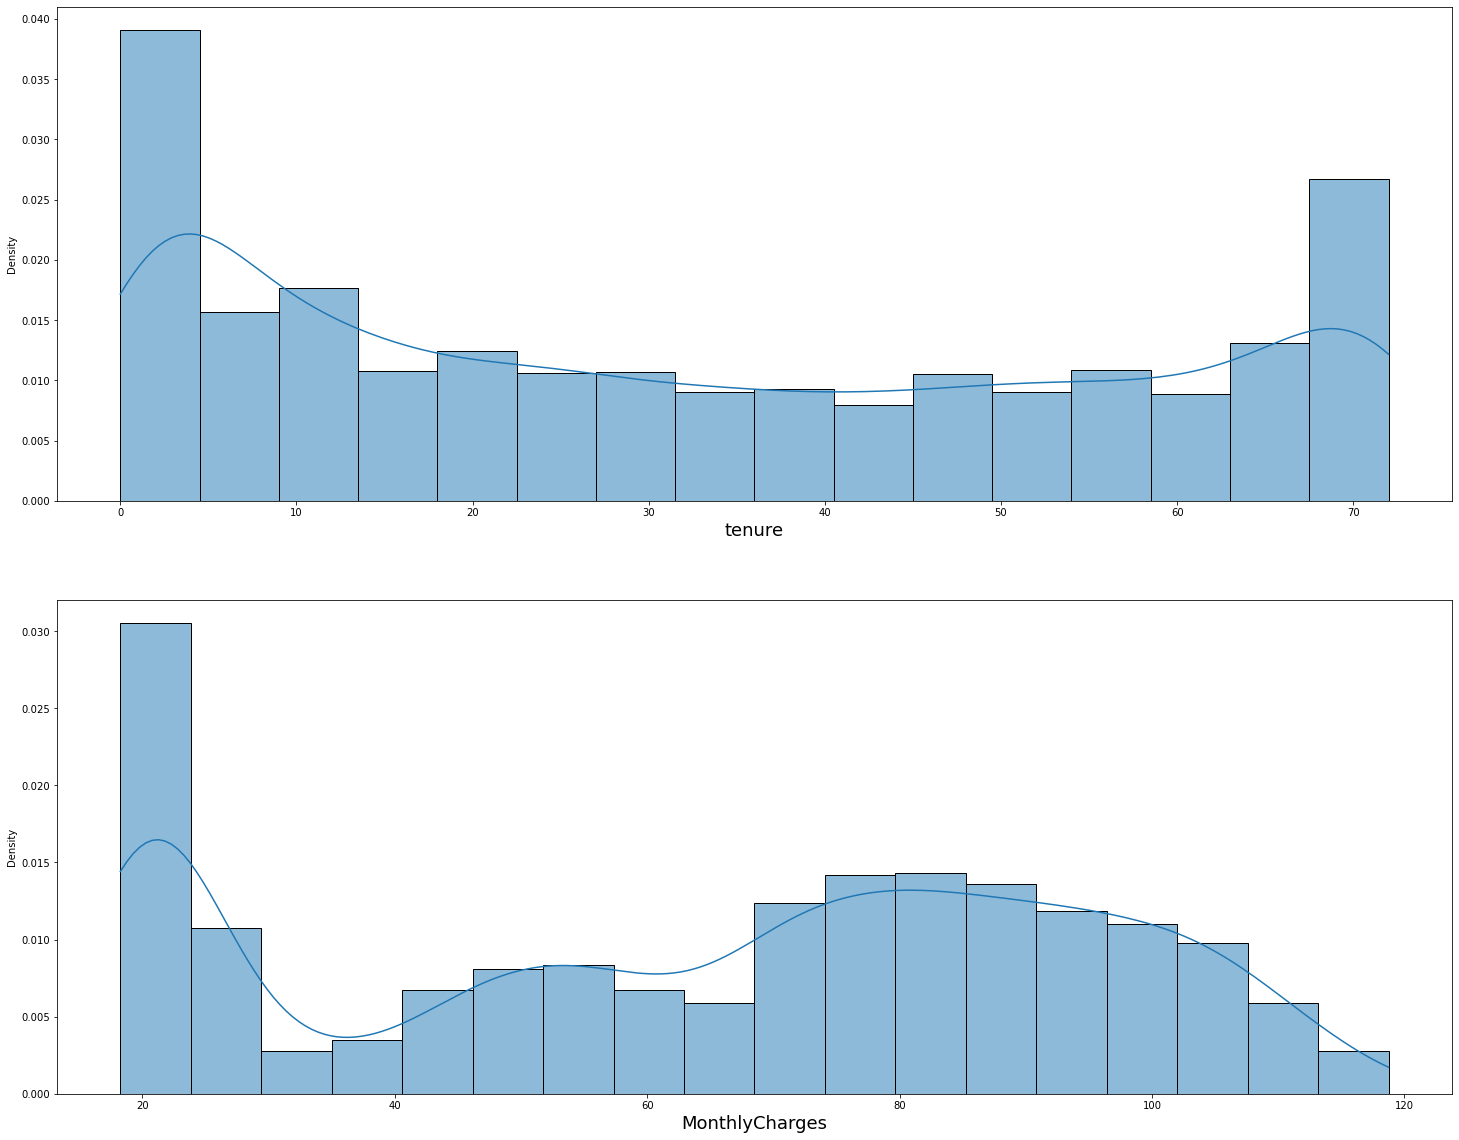

In [32]:
# checking the histogram plots of the numeric features
plt.figure(figsize = (25,20))
plotnumber = 1

for col in numeric_features:
    if(plotnumber < 3):
        plt.subplot(2,1, plotnumber)
        sns.histplot(df[col], kde = True, stat = 'density')
        plt.xlabel(col, fontsize = 18)
    plotnumber += 1
plt.show()

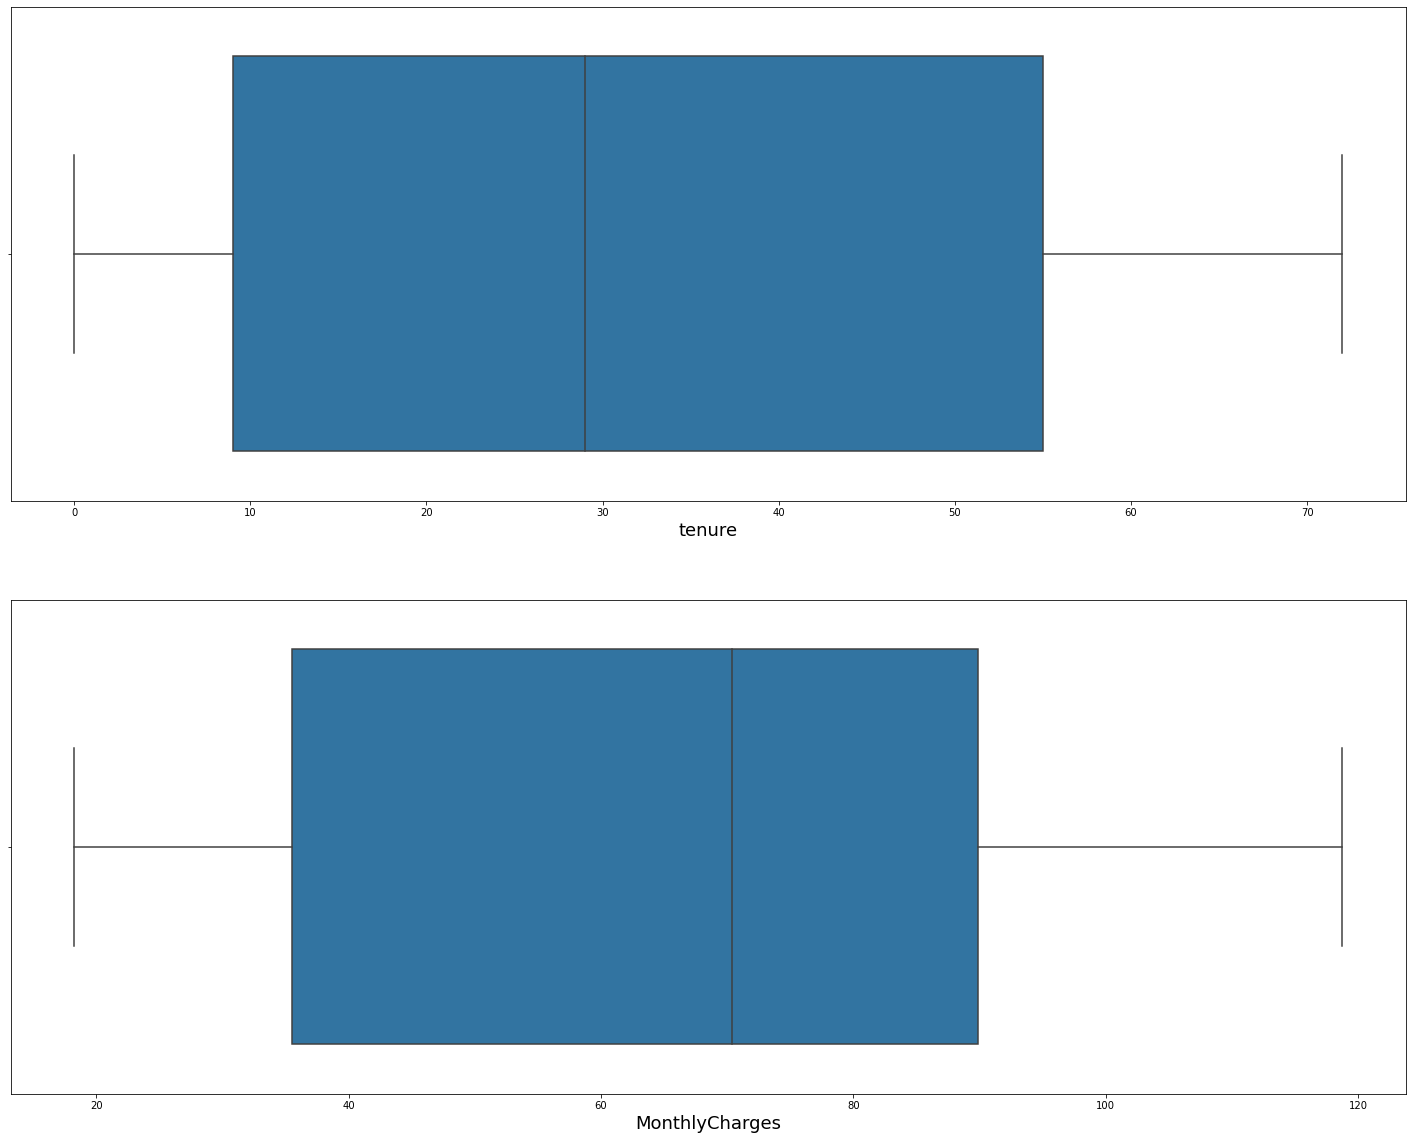

In [33]:
# The features are almost uniformly distributed, we next check for outlier
plt.figure(figsize = (25,20))
plotnumber = 1

for col in numeric_features:
    if(plotnumber < 3):
        plt.subplot(2,1, plotnumber)
        sns.boxplot(df[col], orient = 'h')
        plt.xlabel(col, fontsize = 18)
    plotnumber += 1
plt.show()

In [34]:
# Both the features dont have any outliers

In [35]:
# We next check for the correlation factor each feature shares with the response variable
x = df.drop('Churn', axis = 1)
y = df['Churn'].copy()

In [43]:
import phik
temp = pd.DataFrame()
pvalue = []
score = []
features = []

In [44]:
for col in x.columns:
    if(is_numeric_dtype(x[col])):
        score.append(phik.phik_from_array(x[col], y, [col]))
        pvalue.append(phik.significance.significance_from_array(x[col],y, [col])[0])
        features.append(col)
    else:
        score.append(phik.phik_from_array(x[col], y))
        pvalue.append(phik.significance.significance_from_array(x[col], y)[0])
        features.append(col)

In [45]:
temp['feature'] = features
temp['score'] = score
temp['pvalue'] = pvalue

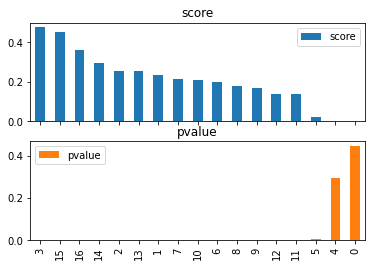

In [51]:
temp.set_index('feature')
temp.sort_values('score', ascending = False).plot.bar(subplots = True)
plt.show()

In [55]:
temp.sort_values('score',ascending = False)

,feature,score,pvalue
3,tenure,0.474001,1.637982e-203
15,PaymentMethod,0.449125,9.345439e-136
16,MonthlyCharges,0.360050,1.165930e-123
14,PaperlessBilling,0.295754,1.655166e-60
2,Dependents,0.253936,3.611090e-46
13,Contract,0.251639,8.673141e-302
1,Partner,0.232930,8.258920e-37
7,OnlineSecurity,0.211840,1.350162e-198
10,TechSupport,0.209021,1.311465e-193
6,InternetService,0.196202,8.326267e-171


In [60]:
# The PhoneService and gender features have no correlation with the target variable and also
# have very high pvalues, implying the null hypothesis cannot be disregarded 
# Hence we drop the two features from the dataset

In [61]:
df.drop(columns = ['PhoneService', 'gender'], inplace = True)

In [64]:
# Next we Encode all the categorical features
binary_features = []
non_binary_features = []
for col in df.columns[:-1]:
    if not is_numeric_dtype(df[col]):
        if(df[col].unique().shape[0] == 2):
            binary_features.append(col)
        else:
            non_binary_features.append(col)

In [69]:
for col in binary_features:
    df[col] = pd.get_dummies(df[col], drop_first = True)

In [86]:
df.head()

,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,1,0,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,No
1,0,0,34,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,No
2,0,0,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,Yes
3,0,0,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,No
4,0,0,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,Yes


In [80]:
# The internet service is an Ordinal Categorical data
from sklearn.preprocessing import OrdinalEncoder

In [92]:
oe = OrdinalEncoder(categories = [['Fiber optic','DSL','No']])

In [94]:
df.loc[:,'InternetService'] = oe.fit_transform(df[['InternetService']])

In [101]:
for col in non_binary_features:
    print(f"{col:30s} : {df[col].unique().shape[0]}")

MultipleLines                  : 3
InternetService                : 3
OnlineSecurity                 : 3
OnlineBackup                   : 3
DeviceProtection               : 3
TechSupport                    : 3
StreamingTV                    : 3
StreamingMovies                : 3
Contract                       : 3
PaymentMethod                  : 4


In [104]:
# we will LabelEncode all the remaining non-binary features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [108]:
for col in non_binary_features:
    df.loc[:,col] = le.fit_transform(df[col]) 

In [111]:
# Ecoding the response variable
df['Churn'] = pd.get_dummies(df['Churn'], drop_first = True)

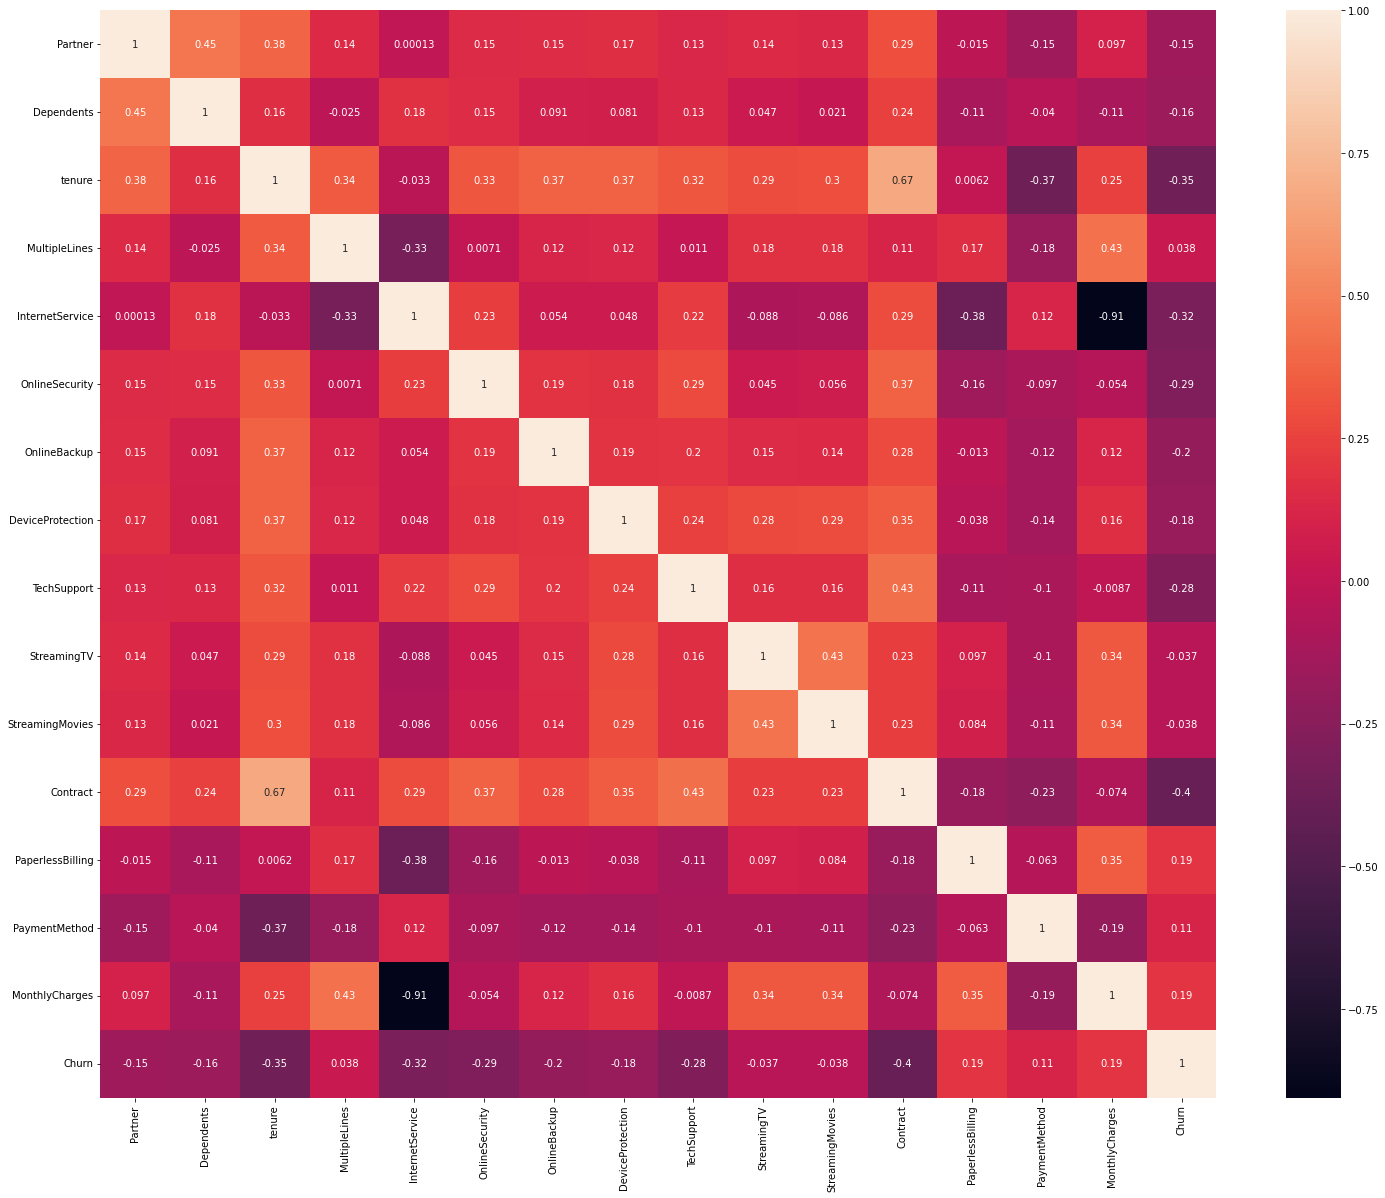

In [113]:
# check for multicolinearity
plt.figure(figsize = (25,20))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [119]:
temp = pd.DataFrame()

In [120]:
temp['feature']   = df.columns[:-1]
temp['VIF Score'] = [vif(df[df.columns[:-1]], i) for i in range(len(df.columns[:-1]))]

In [122]:
temp.sort_values('VIF Score', ascending = False)

,feature,VIF Score
14,MonthlyCharges,12.284381
2,tenure,7.475099
11,Contract,4.108301
4,InternetService,4.019329
13,PaymentMethod,3.603134
10,StreamingMovies,3.198508
9,StreamingTV,3.150329
12,PaperlessBilling,2.892517
0,Partner,2.794329
3,MultipleLines,2.674365


Montly Charges features has a high VIF score, it also has a strong correlation with the InternetService, however both the features have a strong correlation with the response variable.<br>
Hence we do not drop any features in this case

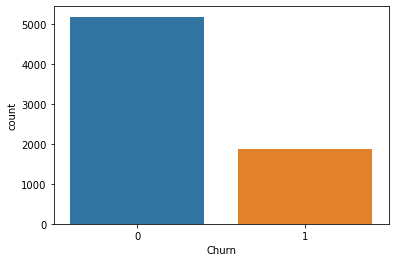

In [124]:
# Checking for class imbalance
sns.countplot(df['Churn'])
plt.show()

In [137]:
print(f"{df[['Churn']].value_counts()/len(df)*100}")

Churn
0        73.463013
1        26.536987
dtype: float64%


In [142]:
# The class is quite imbalanced and hence we upsample the data
from imblearn.over_sampling import RandomOverSampler

In [145]:
x = df.drop('Churn', axis = 1)
y = df['Churn'].copy()

In [146]:
x_resample, y_resample = RandomOverSampler().fit_resample(x,y)

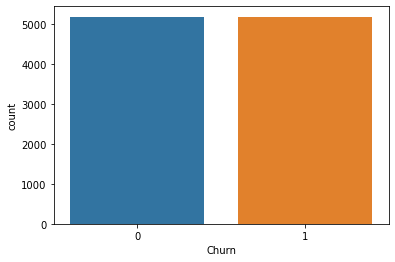

In [149]:
sns.countplot(y_resample)
plt.show()

In [152]:
print(f"{y_resample.value_counts()}")

0    5174
1    5174
Name: Churn, dtype: int64


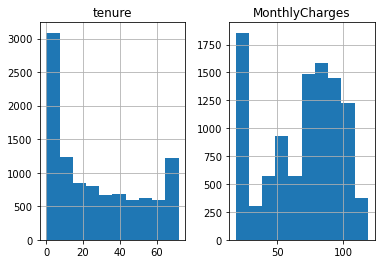

In [163]:
x_resample[numeric_features].hist()
plt.show()

In [157]:
# We use the Power transformer to normalize and standardize the data

In [158]:
from sklearn.preprocessing import PowerTransformer

In [164]:
x_resample[numeric_features] = PowerTransformer().fit_transform(x_resample[numeric_features])

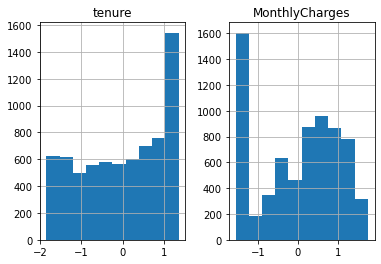

In [165]:
x[numeric_features].hist()
plt.show()

In [171]:
# Splitting the data into a training and test data set
xtrain, xtest, ytrain, ytest = train_test_split(x_resample, y_resample, test_size = 0.2, random_state = 42)

In [172]:
# Building our Logistic regressor models
dt = DecisionTreeClassifier()
lr = LogisticRegression()
kn = KNeighborsClassifier()
rf = RandomForestClassifier()

In [173]:
estimators = []
estimators.append((dt, 'DecisionTreeClassifier'))
estimators.append((lr, 'LogisticRegression'))
estimators.append((kn, 'KNeighborsClassifier'))
estimators.append((rf, 'RandomForestClassifier'))

In [175]:
from sklearn.metrics import accuracy_score, plot_roc_curve
for estimator in estimators:
    estimator[0].fit(xtrain, ytrain)
    ypred = estimator[0].predict(xtest)
    print()
    print(f"{estimator[1]} : {accuracy_score(ytest, ypred)*100:0.3f}%")


DecisionTreeClassifier : 88.116%

LogisticRegression : 77.295%

KNeighborsClassifier : 77.440%

RandomForestClassifier : 89.565%


The DecisionTreeClassifier and the RandomForestClassifier show the best accuracy however we check the ROC curves to best estimate their predictions

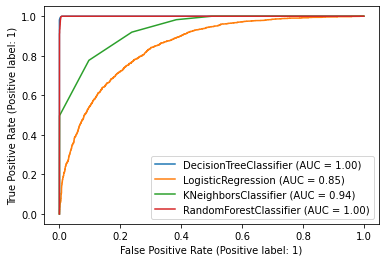

In [176]:
axis = plot_roc_curve(dt, xtrain, ytrain)
for estimator in estimators[1:]:
    plot_roc_curve(estimator[0], xtrain, ytrain, ax = axis.ax_)

<font color = red>The DecisionTreeClassifier and the RandomForestClassifier show a very high AUC value, however we must check the roc on the test data </font>

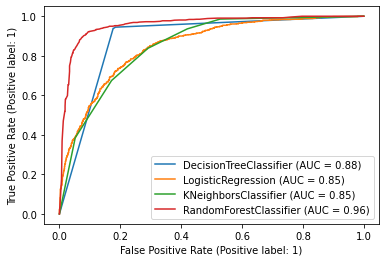

In [177]:
axis = plot_roc_curve(dt, xtest, ytest)
for estimator in estimators[1:]:
    plot_roc_curve(estimator[0], xtest, ytest, ax = axis.ax_)

The estimators show a much realistic estimation on the test data

The RandomForestClassifier is the best estimator and hence we use the GridSearchCV to hypertune and find the best parameters

In [179]:
param_grid = {'n_estimators':[100, 150, 200, 300],
              'criterion' :['gini','entropy'],
              'max_depth' :[2, 3, 4, 5, 6, 7],
              'min_samples_split': [2, 4, 5, 6, 8]}

gs1 = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, n_jobs = -1)
gs1.fit(xtrain, ytrain)
rf_best_est = gs1.best_estimator_

In [180]:
rf_best_est.fit(xtrain, ytrain)
ytest = rf_best_est.predict(xtest)
print(f"{accuracy_score(ytest, ypred)*100:0.3f}%")

85.797%


<font color = green>The GridSearch doesn't give any improvement, hence we use the original RandomForestClassifier estimator</font>

In [182]:
import joblib
joblib.dump(rf, 'LoanStatus.pkl')

['LoanStatus.pkl']